**<h1>Identifying Inappropriate Table of Surgical Procedures (TOSP) Pair Codes with Agglomerative Clustering</h1>**

<p align="justify">
The Table of Surgical Procedures (TOSP) is an exhaustive list of surgical procedures eligible for MediSave/MediShield Life claims. Inappropriate TOSP claims occur when multiple TOSP codes are submitted for a single procedure that could be adequately described by one code. This leads to unnecessary claims and increased healthcare costs.

<p align="justify">
This notebook aims to apply Agglormorative Clustering to flag cases where submitted TOSP codes are too similar and may indicate inappropriate claims. Since no labeled data is provided, the best approach is to use unsupervised learning models. The input data consists primarily of the "Descriptions" column, which captures the textual details of each procedure.

<p align="justify">
Agglomerative Clustering (a hierarchical clustering method) was suggested by Prof. Donny as a potential improvement. Unlike KMeans and DBSCAN, which rely on predefined cluster counts or density thresholds, Agglomerative Clustering builds a hierarchy of clusters, allowing for a more flexible and interpretable structure. Given that TOSP codes naturally form small groups (typically 2-3 similar procedures per cluster), this method may be better suited for detecting inappropriate TOSP code pairs. This notebook will evaluate Agglomerative Clustering and determine if it is the most effective at identifying redundant or overlapping TOSP codes.

---

## **1. Import Libraries and Setup**

Import the necessary libraries to set up the notebook.

In [ ]:
import time
import warnings
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Download Natural Language Toolkit (NLTK)
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **2. Data Loading and Pre-processing**

<p align ="justify">
The "S/N" and "Classification" columns were removed as they do not contribute meaningful information for clustering.

* S/N" is simply a sequential numbering column with no relevance to the model.

* Classification" only indicates whether a TOSP code was newly added, existing, or had a description change, which does not directly impact the clustering process.

<p align ="justify">
To improve text processing, punctuation was removed, and extra spaces were collapsed to maintain consistent word spacing. Additionally, stop words (such as "and," "the," "a"), if any, were eliminated, as they do not provide significant semantic value but increase computational overhead. The remaining words then underwent lemmatization, for better consistency in text representation.

---


In [ ]:
class TOSPPreprocessor:
    def __init__(self):
        self.encode = OneHotEncoder(sparse_output=False)
        self.lemmatizer = WordNetLemmatizer()

    # Function to remove stop words.
    def remove_stopwords(self, description):
        stop_words = set(stopwords.words('english'))

        if isinstance(description, str):
            return ' '.join([word for word in description.split() if word.lower() not in stop_words])
        return description

    # Function to remove punctuation.
    def remove_punctuation(self, description):
        for word in description:
            if word in list(punctuation):
                description = description.replace(word, ' ')

        return description

    # Function for lemmatization.
    def lemmatize_words(self, description):

        # Splits the description into words and lemmatize each word.
        lemmatized_description = ' '.join([self.lemmatizer.lemmatize(word) for word in description.split()])

        return lemmatized_description

    # Collapse more than 1 space (due to removal of punctuation) into a single space.
    def trim_spaces(self, description):
        return re.sub(r'\s+', ' ', description).strip()

    # Get the first 2 characters in the Code column.
    def extract_code(self, code):
        return str(code)[:2]


    def preprocess_data_combined(self, df):

        # Drop unused columns.
        df.drop(columns=['S/N', 'Classification'], inplace=True)

        # Extract code.
        df['Category'] = df['Code'].apply(self.extract_code)
        # df['code_encoded'] = self.encode.fit_transform(df['Code'])


        df['Description'] = df['Description'].apply(self.remove_punctuation)
        df['Description'] = df['Description'].apply(self.trim_spaces)
        df['Description'] = df['Description'].apply(self.remove_stopwords)
        df['Description'] = df['Description'].apply(self.lemmatize_words)

        # Make description lower case.
        df['Description'] = df['Description'].str.lower()


        return df

Importing the dataset and display some of the details:

In [ ]:
category_dict = {"SA": "Integumentary",
                 "SB": "Musculoskeletal",
                 "SC": "Respiratory",
                 "SD": "Cardiovascular",
                 "SE": "Hemic & Lymphatic",
                 "SF": "Digestive",
                 "SG": "Urinary",
                 "SH": "Male Genital",
                 "SI": "Female Genital",
                 "SJ": "Endocrine",
                 "SK": "Nervous",
                 "SL": "Eye",
                 "SM": "ENT"}

# Import data.
df = pd.read_csv("combined_dataset.csv")
print(df.head())

# Print count of rows
print(df['Description'].size, "\n")

# Check for NaN values in any rows.
empty_values = (df.isna() | (df == '')).sum()
print(empty_values)


   S/N    Code                                        Description Table  \
0    1  SA700B     BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS   MSP   
1    2  SA701B  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILAT...    3A   
2    3  SA702B  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILA...    2C   
3    4  SA704B  BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED ...    2B   
4    5  SA705B  BREAST, LUMP (REMOVAL) WITH PARENCHYMAL FLAP C...    4A   

      Classification  
0           Existing  
1           Existing  
2           Existing  
3           Existing  
4  Descriptor Change  
2363 

S/N               0
Code              0
Description       0
Table             0
Classification    0
dtype: int64


Make a copy of the original descriptions before pre-processing, then peform preprocessing of the [Descriptions] column.

In [ ]:
# Make a copy of the original descriptions.
sentences = df['Description'].to_list()
df['original_description'] = df['Description'].copy()

# Peform preprocessing on the Descriptions column.
preprocessor = TOSPPreprocessor()
processed_data = preprocessor.preprocess_data_combined(df)
df = processed_data

print(df.head())

     Code                                        Description Table  \
0  SA700B         botulinum toxin therapy movement disorders   MSP   
1  SA701B    breast ductal lesions microdochectomy bilateral    3A   
2  SA702B   breast ductal lesions microdochectomy unilateral    2C   
3  SA704B  breast lumps imaging guided vacuum assisted bi...    2B   
4  SA705B  breast lump removal parenchymal flap closure u...    4A   

                                original_description Category  
0     BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS       SA  
1  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILAT...       SA  
2  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILA...       SA  
3  BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED ...       SA  
4  BREAST, LUMP (REMOVAL) WITH PARENCHYMAL FLAP C...       SA  


## **Using Sentence Transformers for Encoding Textual Descriptions**

<p align="justify">
Instead of using traditional methods like TF‑IDF, which only captures word frequency and ignores semantic meaning, we use Sentence Transformers, which generate dense embeddings that capture contextual relationships between words. Specifically, we use the all-MiniLM-L6-v2 model, a popular compact and efficient transformer-based model that balances performance and computational efficiency.



In [ ]:
# Use sentence transformer to encode the textual descriptions.
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **3. Defining functions to use for visualisation and displaying test results**



### **3.1 Defining plot_figure()**

<p align="justify">
The first function, plot_figure(), creates an interactive 3D scatter plot using Plotly to visualise how TOSP codes are grouped based on their embeddings. It takes a set of dimensionality-reduced embeddings (PCA will be used) and plots them along three axes (PC1, PC2, and PC3). The function also supports text hovering so that individual TOSP descriptions can be examined, making it easier to interpret whether similar procedures are clustering together.

In [ ]:
# Function to plot a 3D graph.
def plot_figure(embeddings_reduced, df_original_descr, plot_title, color_map=None):
  fig = go.Figure()

  fig.add_trace(go.Scatter3d(
      x=embeddings_reduced[:, 0],
      y=embeddings_reduced[:, 1],
      z=embeddings_reduced[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color = 'blue' if color_map is None else color_map,
          opacity=0.8
      ),
      text=df_original_descr, # Hover text
      hoverinfo="text",  # Display only the text on hover
  ))


  fig.update_layout(
      title=plot_title,
      scene=dict(

          xaxis_title="PC1",
          yaxis_title="PC2",
          zaxis_title="PC3"
      ),

  )

  fig.show()

### **3.2 Defining test_df_tosp()**

<p align="justify">
The second function, test_df_tosp(), evaluates the "combined_dataset.csv" to check for potentially inappropriate code pairs. If two codes belong to the same cluster, they are flagged as inappropriate and printed. The function also keeps a count of the total number of inappropriate pairs detected. We will also limit to only display 10 pairs as there are > 800 pairs after testing.

In [ ]:
# Function to test a whole dataset (more than 2 rows) and limit output to 10 pairs.
pd.set_option('display.max_colwidth', None)

def test_df_tosp(test_csv, tosp_labels_df, max_display=10):
    inappr_counter = 0
    displayed_count = 0  # Counter for printed pairs

    test_df = pd.read_csv(test_csv)
    rows = tosp_labels_df[tosp_labels_df["Code"].isin(test_df["Code"])]

    for i in range(0, len(rows)):
        for j in range(i + 1, len(rows)):
            if rows["Labels"].iloc[i] == rows["Labels"].iloc[j]:
                if displayed_count < max_display:  # Limit to max_display (default 10)
                    print(f"{rows['original_description'].iloc[i]}\n{rows['original_description'].iloc[j]}\n")
                    print(f"Inappropriate code pair detected: {rows['Code'].iloc[i]} and {rows['Code'].iloc[j]}\n")
                    displayed_count += 1

                inappr_counter += 1

    print(f"Total inappropriate pairs detected: {inappr_counter} (Showing the first {max_display} pairs only)\n")

### **3.3 Defining test_case_tosp()**

<p align="justify">
The third function, test_case_tosp(), is a simplified version of the second but is designed for testing just two TOSP codes. It reads the test file containing two TOSP codes (deliberately selected)  and retrieves the cluster labels for both codes. If the two codes are assigned to the same cluster, they are classified as inappropriate; otherwise, they are considered valid.

In [ ]:
# Function to test a csv file with only 2 rows.
def test_case_tosp(test_csv, tosp_labels_df):
  test_df = pd.read_csv(test_csv)

  rows = tosp_labels_df[tosp_labels_df["Code"].isin(test_df["Code"])]


  if (rows["Labels"].iloc[0] == rows["Labels"].iloc[1]):
    print(f"{rows['original_description'].iloc[0]}\n{rows['original_description'].iloc[1]}\n")
    print(f"Inappropriate code pair detected: {rows['Code'].iloc[0]} and {rows['Code'].iloc[1]}\n")

  else:
    print(f"{rows['original_description'].iloc[0]}\n{rows['original_description'].iloc[1]}\n")
    print("Valid code pair.\n")

## **4. Reducing dimension for visualising the dataset**

<p align="justify">
Since the original embeddings generated by all-MiniLM-L6-v2 are 384-dimensional vectors, they cannot be directly visualized in a 3D space. Principal Component Analysis(PCA) was applied to reduce it to 3 dimensions (PC1, PC2, PC3), allowing us to use the 3D scatter plot.

---

In [ ]:
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

plot_figure(reduced_embeddings, df["original_description"], "Dataset Visualisation", color_map=None)

## **5. Agglomerative Clustering**

The starting value of the n_values range is determined based on domain knowledge and a worst-case scenario estimation. In the worst case, each TOSP code is unique and should be clustered with at most one other code, leading to an estimate of at least 1000 clusters (2364 TOSP codes). Setting n_clusters ≥ 1000 ensures that distinct procedures are not incorrectly grouped together, allowing only highly similar codes to be merged while maintaining a fine-grained clustering structure.

---

# 5.1 Finding the Best n_clusters Value with Davies Bouldin Index/Score

Time taken: 49.28926086425781s


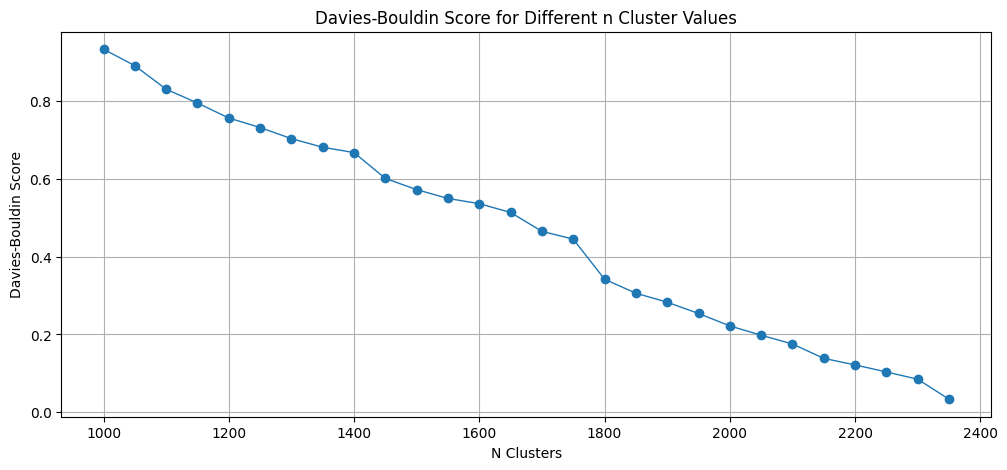

In [ ]:
dbi_history = []
n_values = np.arange(1000, df.shape[0], 50)

start_time = time.time()
for n in n_values:
  agg_clf = AgglomerativeClustering(n_clusters=n, linkage='single', metric='cosine')
  agg_clf.fit(embeddings)

  score = davies_bouldin_score(embeddings, agg_clf.labels_)

  dbi_history.append(score)

print(f"Time taken: {(time.time() - start_time)}s")
plt.figure(figsize=(12, 5))

plt.plot(n_values, dbi_history, 'o', ls='-', lw=1)
plt.title(f"Davies-Bouldin Score for Different n Cluster Values")
plt.xlabel("N Clusters")
plt.ylabel("Davies-Bouldin Score")

plt.grid()
plt.show()

<p align="justify">
As Agglomerative Clustering does not assign points to fixed cluster centers, Silhouette Score is less meaningful since there are no clear distances to cluster centers. Davies-Bouldin Score compares intra-cluster distances and inter-cluster separation, which might be better suited for hierarchical methods like Agglomerative Clustering.

<p align="justify">
Based on domain knowledge and to prevent overfitting, values beyond 2000 clusters will not be considered. A sharp drop in the score around 1800 clusters indicates improved cluster separation compared to earlier values. After 1800 clusters, the score continues to decrease gradually, suggesting diminishing returns and potential overfitting. Therefore, 1800 clusters is chosen as the optimal value for the Agglomerative Clustering model.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
start_time = time.time()
agg_clf = AgglomerativeClustering(n_clusters=1800, linkage='single', metric='cosine')
predictions = agg_clf.fit_predict(embeddings)

df["Labels"] = predictions
print(f"Time taken: {(time.time() - start_time)}s")
print("Total number of unique labels:",df["Labels"].nunique())

Time taken: 0.8019077777862549s
Total number of unique labels: 1800


In [ ]:
test_df_tosp("combined_dataset.csv", df)

# Create a color mapping based on unique labels
unique_labels = df["Labels"].unique()
eye_color_map = {label: f"rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})" for label in unique_labels}
df["color"] = df["Labels"].map(eye_color_map)

plot_figure(embeddings, df["Labels"].astype(str) + ": " + df["original_description"], "Clustering Visualization", color_map=df["color"])

BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)
BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)

Inappropriate code pair detected: SA701B and SA702B

BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, SINGLE LESION
BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, > 1 LESIONS

Inappropriate code pair detected: SA704B and SA706B

BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH SENTINEL NODE BIOPSY/ AXILIARY NODE SAMPLING
BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH AXILIARY CLEARANCE, WITH/WITHOUT SENTINEL NODE BIOPSY

Inappropriate code pair detected: SA707B and SA823B

BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH SENTINEL NODE BIOPSY/ AXILIARY NODE SAMPLING
BREAST TUMOUR (MALIGNANT, VARIOUS LESIONS), SIMPLE MASTECTOMY WITH AXILLARY CLEARANCE, WITH/WITHOUT SENTINEL NODE BIOPSY

Inappropriate code pair detected:

<p align = "justify">
The labels were tested on a subset of the original dataset, specifically SJ_Endocrine.csv, which contains 15 rows. This smaller dataset was chosen because it is more manageable and allows for better verification of results, as it focuses on a specific category of operations (Endocrine surgeries).

At a glance, several inappropriate TOSP code pairs exist within the dataset, such as:

    THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY
    THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)
    THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
    THYROID, VARIOUS LESIONS, TOTAL THYROIDECTOMY, COMPLEX (RECURRENCE), WITH/WITHOUT STERNAL SPLIT
    THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY

In [ ]:
test_df_tosp("SJ_Endocrine.csv", df)

PARATHYROID, VARIOUS LESIONS, EXCISION
PARATHYROID, VARIOUS LESIONS, RE EXPLORATION

Inappropriate code pair detected: SJ800P and SJ801P

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)

Inappropriate code pair detected: SJ703T and SJ804T

Total inappropriate pairs detected: 2 (Showing the first 10 pairs only)



<p align="Justify">
However, despite the presence of clearly similar procedures, the model only detected two pairs of invalid TOSP codes, indicating low accuracy in identifying inappropriate code pairs. The current clustering approach may not fully capture the relationships between similar procedures, likely due to inadequate feature representation and suboptimal clustering parameters.

## **6. Evaluating the Model Against Test Cases**

<p align="justify">
The Agglomerative Clustering model was tested using 7 different TOSP code pairs, with the first 5 being inappropriate code pairs and the last 2 being valid ones. These test cases were designed to evaluate how well the model detects semantic similarities in TOSP descriptions, considering factors such as word differences, description length, and context.


> Test 1 Pair: 1 word difference, same length (MAJOR, MINOR) -> **INVALID** <br>
SA711S: SOFT TISSUE (LOWER LIMB), CONTRACTURE, MAJOR RELEASE <br>
SA712S: SOFT TISSUE (LOWER LIMB), CONTRACTURE, MINOR RELEASE <br>

<br>

> Test 2 Pair: 1 word difference, different length (BILATERAL) -> **INVALID** <br>
SL701L: LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY <br>
SL702L: LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL <br>

<br>

> Test 3 Pair: 2 word difference, different length (BILATERAL, UNILATERAL LEFT) -> **INVALID**  <br>
SL807L: LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (BILATERAL) <br>
SL808L: LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT) <br>

<br>

> Test 4 Pair: 2 word difference, same length (BONE GRAFT, ALLOPLASTIC MATERIAL)  -> **INVALID** <br>
SL809O: ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH BONE GRAFT <br>
SL810O: ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH ALLOPLASTIC MATERIAL <br>

<br>




> Test 5 Pair: 3 word difference, different length (WITH BLOCK NECK DISSECTION)  -> **INVALID** <br>
SM712L: LARYNX, TUMOR, PARTIAL LARYNGECTOMY <br>
SM713L: LARYNX, TUMOR, PARTIAL LARYNGECTOMY WITH BLOCK NECK DISSECTION <br>

<br>



> Test 6 Pair: Valid code pair, sufficiently different words with different meanings  -> **VALID** <br>
SM818E: EAR, MICROTIA, CREATION OF POST-AURICULAR SULCUS WITH SKIN GRAFT <br>
SM819E: EAR, MICROTIA, INSERTION OF CARTILAGE/SILASTIC FRAMEWORK <br>

<br>




> Test 7 Pair: Valid code pair, sufficiently different words with different meanings  -> **VALID** <br>
SB716F: FOOT, CONGENITAL TALIPES EQUINOVARUS (CTEV), BILATERAL RELEASE <br>
SB725F: FOOT, ONE BONE OSTEOTOMY WITH SOFT TISSUE RELEASE, CUBOID <br>

---

In [ ]:
# Loading the test cases.

test_case_tosp("test1.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test2.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test3.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test4.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test5.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test6.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test7.csv", df)
print("--------------------------------------------------------------------------------------------------")

SOFT TISSUE (LOWER LIMB), CONTRACTURE, MAJOR RELEASE
SOFT TISSUE (LOWER LIMB), CONTRACTURE, MINOR RELEASE

Inappropriate code pair detected: SA711S and SA712S

--------------------------------------------------------------------------------------------------
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL

Inappropriate code pair detected: SL701L and SL702L

--------------------------------------------------------------------------------------------------
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (BILATERAL)
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT)

Inappropriate code pair detected: SL807L and SL808L

--------------------------------------------------------------------------------------------------
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH BONE GRAFT
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH ALLOPLASTIC MATERIAL

# **6.1 Results and Observations**

<p align="Justify">
The model correctly identified both valid code pairs, confirming that it can distinguish unrelated procedures effectively. However, for the 5 inappropriate TOSP pairs, the model only detected 3 correctly, misidentifying two inappropriate pairs even when their descriptions differed by only two words.

<p align="Justify">
A key observation is that the model performs better when the descriptions have a small word difference (≤ 2 words), especially if they have different lengths. However, it struggles when the descriptions are of similar length but contain distinct terms, as seen in Test 4, where the presence of two different words at the end caused the model to classify them as separate codes.

## **7. Training Agglomerative Clustering Model on Individual Datasets**

<p align="Justify">
We will now train the Agglomerative Clustering model on individual datasets to analyze how well it groups TOSP codes based on their textual descriptions. By applying the model separately to smaller specific datasets, we can assess its performance across various medical procedure categories and determine if the model will perform better with specialised surgical domains.

## **7.1 Endocrine Dataset (SJ_Endocrine.csv)**

<p align="Justify">
SJ_Endocrine.csv contains just 15 different Endocrine related surgical procedures, making it easier for us to observe if the clustering is effective.

In [ ]:
def test_agg_model(dataset_csv, test_start, test_step):
  df = pd.read_csv(dataset_csv)
  sentences = df['Description'].to_list()

  df['original_description'] = df['Description'].copy()

  # Peform preprocessing on the Descriptions column.
  preprocessor = TOSPPreprocessor()
  processed_data = preprocessor.preprocess_data_combined(df)
  df = processed_data

  model = SentenceTransformer('all-MiniLM-L6-v2')
  embeddings = model.encode(sentences)

  dbi_history = []
  n_values = np.arange(test_start, df.shape[0], test_step)

  for n in n_values:
    agg_clf = AgglomerativeClustering(n_clusters=n, linkage='single', metric='cosine')
    agg_clf.fit(embeddings)

    score = davies_bouldin_score(embeddings, agg_clf.labels_)

    dbi_history.append(score)

  plt.figure(figsize=(12, 5))

  plt.plot(n_values, dbi_history, 'o', ls='-', lw=1)
  plt.title(f"Davies-Bouldin Score for Different n Cluster Values")
  plt.xlabel("N Clusters")
  plt.ylabel("Davies-Bouldin Score")

  plt.grid()
  plt.show()

  return df, embeddings

def train_model(df, embeddings, n_clusters):
  agg_clf = AgglomerativeClustering(n_clusters=n_clusters, linkage='single', metric='cosine')
  predictions = agg_clf.fit_predict(embeddings)

  df["Labels"] = predictions
  print("Total number of unique labels:", df["Labels"].nunique())

  return df

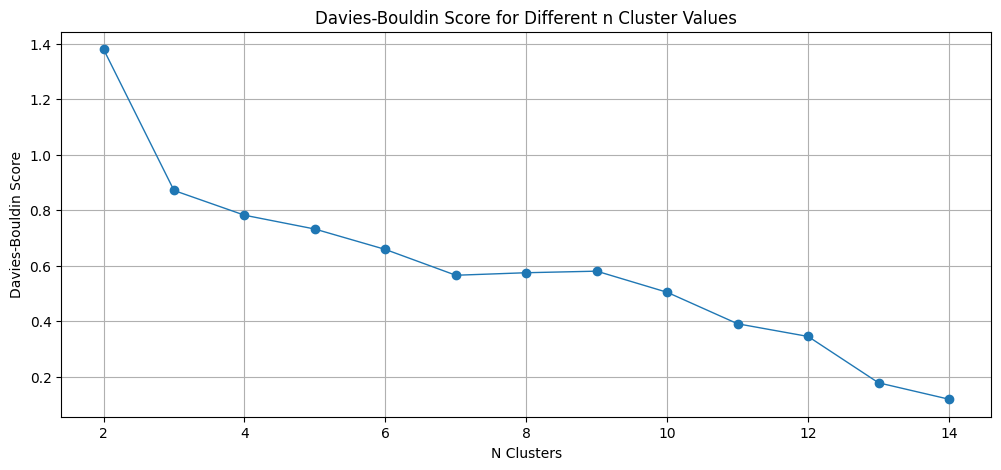

In [ ]:
df_embeddings = test_agg_model("SJ_Endocrine.csv", 2, 1)

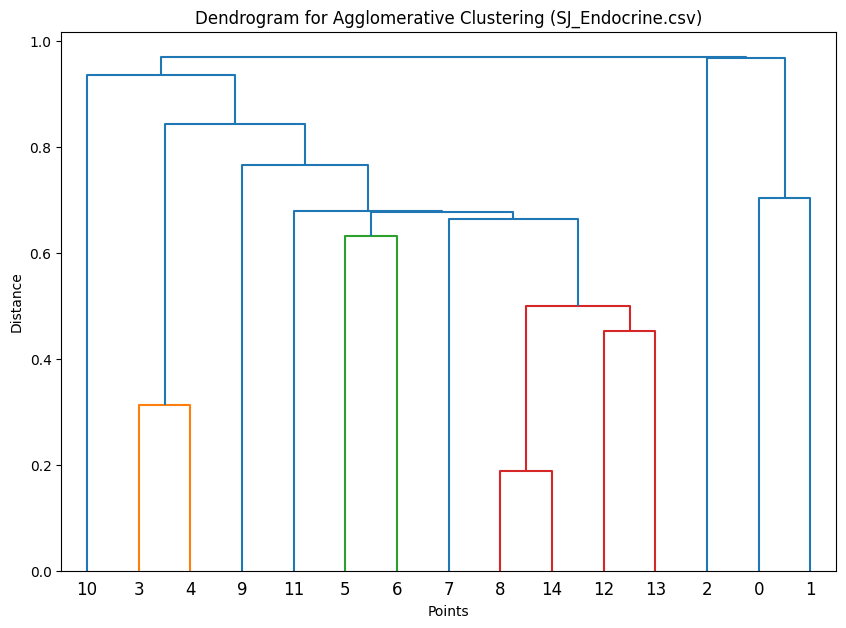

In [ ]:
linked = linkage(df_embeddings[1], method='single')

plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.66)

plt.title("Dendrogram for Agglomerative Clustering (SJ_Endocrine.csv)")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

Based on the dendogram and the DBI score, we determined that n_clusters = 10 would be the most suitable for this dataset.

In [ ]:
df_result = train_model(df_embeddings[0], df_embeddings[1], 10)
test_df_tosp("SJ_Endocrine.csv", df_result)

Total number of unique labels: 10
PARATHYROID, VARIOUS LESIONS, EXCISION
PARATHYROID, VARIOUS LESIONS, RE EXPLORATION

Inappropriate code pair detected: SJ800P and SJ801P

THYROID, VARIOUS LESIONS, NEEDLE BIOPSY
THYROID, VARIOUS LESIONS, IMAGING GUIDED PERCUTANEOUS ASPIRATION/BIOPSY

Inappropriate code pair detected: SJ700T and SJ701T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY

Inappropriate code pair detected: SJ703T and SJ802T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY

Inappropriate code pair detected: SJ703T and SJ803T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)

Inappropriate code pair detected: SJ703T and SJ804T

THYROID, VARIOUS LESIONS, 

In [ ]:
unique_labels = df_result["Labels"].unique()
eye_color_map = {label: f"rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})" for label in unique_labels}
df_result["color"] = df_result["Labels"].map(eye_color_map)

plot_figure(df_embeddings[1], df_result["Labels"].astype(str) + ": " + df_result["original_description"], "Clustering Visualization", color_map=df_result["color"])

<p align="Justify">
By examining the plot, we can observe some inaccuracies in the clustering results. Specifically, "THYROID, VARIOUS LESIONS, TOTAL THYROIDECTOMY, COMPLEX (RECURRENCE), WITH/WITHOUT STERNAL SPLIT" was not grouped together with other thyroidectomy-related procedures, despite its similarity in terminology.

<p align="Justify">
This discrepancy could be attributed to the vectorization process used for textual descriptions. Since sentence embeddings rely on contextual meaning, certain phrases may be interpreted differently, causing them to be positioned farther apart in the embedding space. As a result, procedures that should ideally be grouped together may fall into separate clusters.



## **7.2 Another Example - Eye Dataset (SL_Eye.csv)**

<p align="Justify">
SL_eye.csv is a more complex subset, with 175 different surgical procedures.

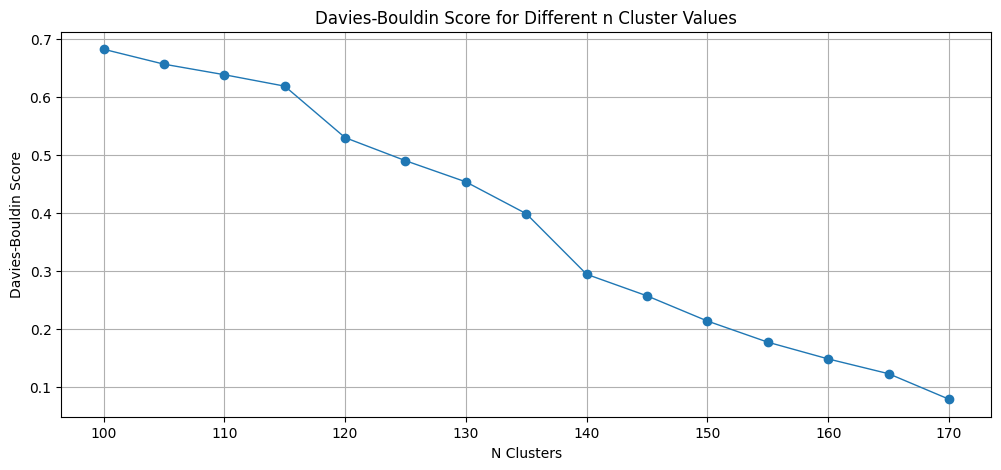

In [ ]:
df_embeddings = test_agg_model("SL_Eye.csv", 100, 5)

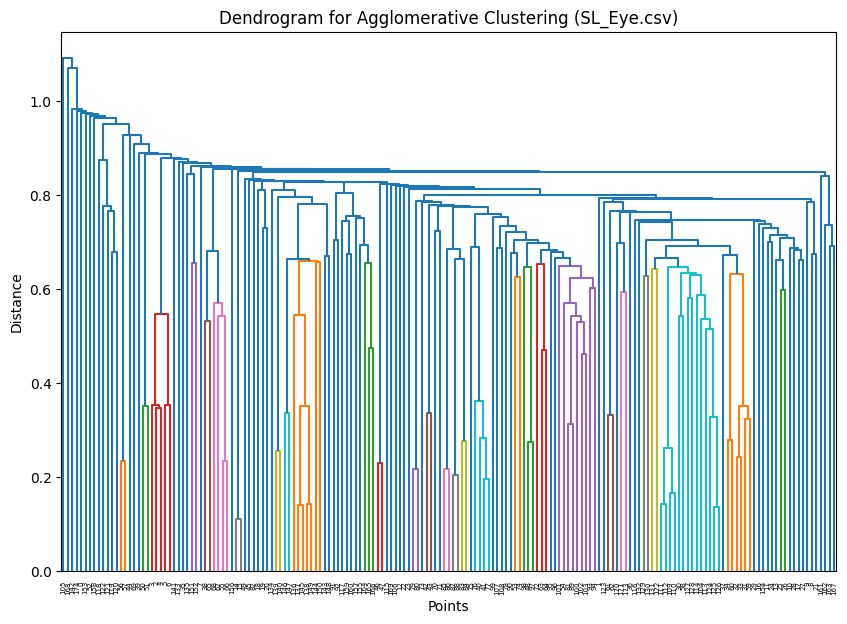

In [ ]:
linked = linkage(df_embeddings[1], method='single')

plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.66)

plt.title("Dendrogram for Agglomerative Clustering (SL_Eye.csv)")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

Based on DBI (the dendogram is difficult to inteprete), the optimal n_clusters value is about 140.

In [ ]:
df_result_endo = train_model(df_embeddings[0], df_embeddings[1], 140)

test_df_tosp("SL_Eye.csv", df_result_endo)

Total number of unique labels: 140
BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT

Inappropriate code pair detected: SL700B and SL701B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL

Inappropriate code pair detected: SL700B and SL702B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT
BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL

Inappropriate code pair detected: SL701B and SL702B

BROW, DIRECT BROWPLASTY, BILATERAL
BROW, DIRECT BROWPLASTY, UNILATERAL

Inappropriate code pair detected: SL703B and SL704B

CORNEAL/OCULAR SURFACE, OSTEO-ODONTO- KERATOPROSTHESIS STAGE 1
CORNEAL/OCULAR SURFACE, OSTEO-ODONTO- KERATOPROSTHESIS STAGE 2

Inappropriate code pair detected: SL706C and SL707C

EYE, GLAUCOMA, GONIOTOMY/TRABECULOTOMY (BILATERAL)
EYE, GLAUCOMA, GONIOTOMY/TRABECULOTOMY (BILATERAL) - PAEDIATRIC

Inappropriate code pair detected: SL701E and SL702E

EYE, GLAUCOMA, GONIOTOMY/TRABECULOTOMY (BILATERAL)
EYE, GLA

In [ ]:
unique_labels = df_result_endo["Labels"].unique()
eye_color_map = {label: f"rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})" for label in unique_labels}
df_result_endo["color"] = df_result_endo["Labels"].map(eye_color_map)

plot_figure(df_embeddings[1], df_result_endo["Labels"].astype(str) + ": " + df_result_endo["original_description"], "Clustering Visualization", color_map=df_result_endo["color"])

## **8. Saving the Agglormorative Model**

<p align="justify">
To avoid retraining, we save the trained Agglormorative model using joblib. This allows us to reuse them later without recomputing clusters.

In [ ]:
import joblib

# Save Agglormorative model
joblib.dump(agg_clf, "Agglormorative_Model.pkl")

print("Agglormorative_Model Clustering Model saved successfully!")

Agglormorative_Model Clustering Model saved successfully!


##  **9. Conclusion**

<p align="Justify">
In this notebook, Agglomerative Clustering was explored to solve the problem of clustering TOSP codes to flag inappropriate pairs when a claim is submitted. By applying hierarchical clustering techniques, the model aimed to group similar surgical procedures together based on their textual descriptions and detect cases where multiple TOSP codes might be inappropriately used together.

# **Rationale of using the Agglomerative Clustering**

<p align="Justify">
Agglomerative Clustering was chosen as it is a hierarchical clustering method, meaning it does not require a predefined number of clusters but instead allows for an exploratory approach to determine the optimal number of groups.

# **Accuracy**

<p align="Justify">
The Agglomerative Clustering model successfully grouped TOSP descriptions with minor variations, particularly when the difference between descriptions was one or two words or when length variations were minimal. However, some inaccuracies were observed, particularly in cases where descriptions contained similar phrases but described fundamentally different procedures.

For example, the following two TOSP codes were incorrectly clustered together due to shared leading words, despite being distinct procedures:

    THYROID, VARIOUS LESIONS, NEEDLE BIOPSY
    THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY

This suggests that while Agglomerative Clustering effectively groups similar codes, it may struggle with nuanced semantic differences that require deeper language understanding.


# **Model Size and Computation Speed**

# Agglomerative Clustering

* When applied to the entire TOSP dataset, the process of finding the optimal n_clusters took approximately 51 seconds (dependent on hardware).

* Once the best n_clusters value was determined, the actual training time for clustering was 0.8 seconds (dependent on hardware).

* The range of n_clusters tested spanned 1000 to 2364 (total number of rows), with increments of 50 per step.

<p align="Justify">
Overall, the model demonstrated decent performance, with low computational requirements for both training and inference. The results indicate that Agglomerative Clustering is suitable for large-scale TOSP code grouping while maintaining reasonable accuracy in detecting inappropriate code pairs.

<p align="Justify">
However, to further improve accuracy and reduce false positives, additional techniques such as enhanced text preprocessing, improved vectorisation methods, or hybrid clustering approaches could be explored.

In the next notebook, we will explore Non-negative Matrix Factorization (NMF) to analyze TOSP code descriptions and identify inappropriate code pairs.